In [1]:
#     --resume "weights/detr-r50_no-class-head.pth" \
# --start_epoch 20 \
!python main.py \
    --dataset_file "oral" \
    --data_path "/home/wenisch/Atom360/AI/Learning/data/dataset" \
    --output_dir "outputs" \
    --resume "weights/detr-r50_no-class-head2.pth" \
    --batch_size 1 \
    --num_queries 5 \
    --epochs 20 \

Not using distributed mode
git:
  sha: 8a144f83a287f4d3fece4acdf073f387c5af387d, status: has uncommited changes, branch: detection

Namespace(aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, data_path='/home/wenisch/Atom360/AI/Learning/data/dataset', dataset_file='oral', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=20, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='weights/detr-r50_no-class-head2.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41279752
loading annotations into memory...

In [2]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

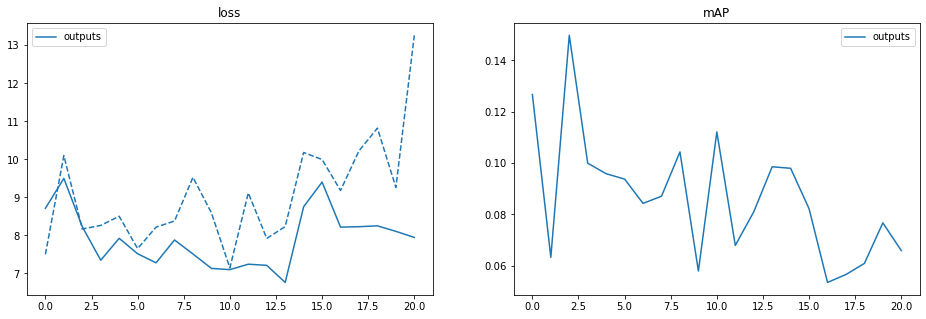

In [3]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

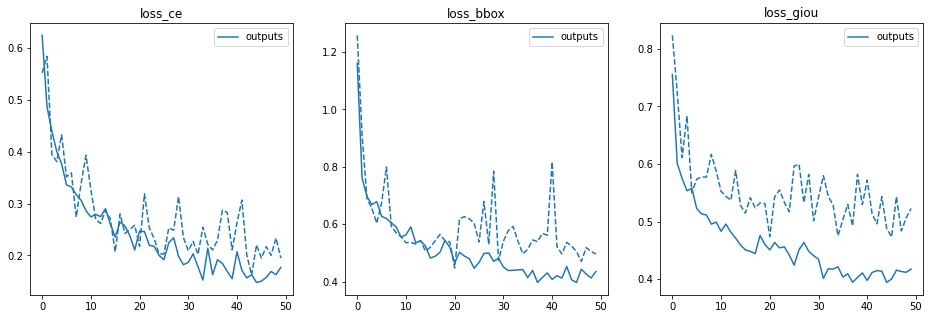

In [47]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

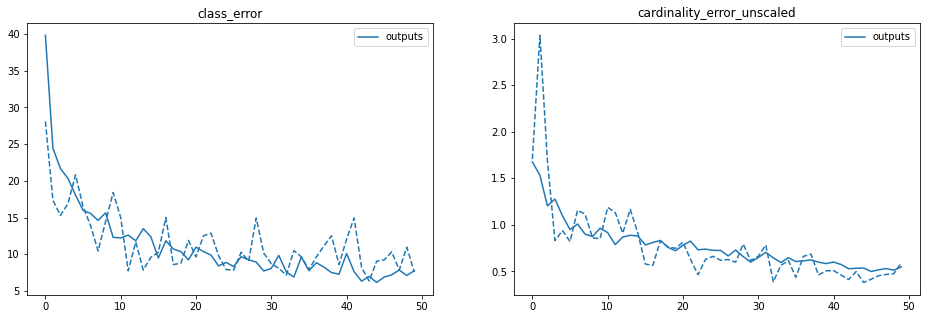

In [48]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)

#### Get Pretrained Weights
uncomment for downloading weights

In [49]:
# import torch
# checkpoint = torch.hub.load_state_dict_from_url(
#             url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
#             map_location='cpu',
#             check_hash=True)

# # Remove class weights
# del checkpoint["model"]["class_embed.weight"]
# del checkpoint["model"]["class_embed.bias"]
# # del checkpoint["model"]["query_embed.weight"]

# # Save
# torch.save(checkpoint,
#            'weights/detr-r50_no-class-head2.pth')

### Test the model

In [26]:
!python test.py \
    --dataset_file "oral" \
    --data_path "/home/wenisch/Atom360/AI/Learning/data/dataset" \
    --resume "outputs/checkpoint.pth"

processing...000526crack.jpg
Traceback (most recent call last):
  File "test.py", line 234, in <module>
    infer(image_paths, model, postprocessors, device, args.output_dir)
  File "/home/wenisch/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "test.py", line 144, in infer
    image, targets = transform(orig_image, dummy_target)
  File "/home/wenisch/Atom360/AI/Learning/algo/detr/datasets/transforms.py", line 267, in __call__
    image, target = t(image, target)
  File "/home/wenisch/Atom360/AI/Learning/algo/detr/datasets/transforms.py", line 267, in __call__
    image, target = t(image, target)
  File "/home/wenisch/Atom360/AI/Learning/algo/detr/datasets/transforms.py", line 248, in __call__
    image = F.normalize(image, mean=self.mean, std=self.std)
  File "/home/wenisch/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/functional.py", line 363, in normalize

### Load the fine-tuned model

In [5]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

num_classes = 3
finetuned_classes = ['N/A', 'spall', 'rebar', 'crack']
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /home/wenisch/.cache/torch/hub/facebookresearch_detr_main


In [7]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
  
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
    
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [19]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)
  # print(outputs)
  for threshold in [0.9, 0.5, 0.1]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


### With a training image

{'pred_logits': tensor([[[-13.6711,  -2.3336,  -2.0808,   3.5310],
         [-10.9810,  -0.6151,  -1.4271,   2.3854],
         [-14.6080,  -1.2186,  -1.3815,   3.0546],
         [-11.3103,  -0.5726,  -0.9610,   2.2662],
         [-14.1758,  -0.9332,  -0.7676,   2.5257],
         [-13.9388,  -0.9590,  -0.9674,   2.6481],
         [-13.3117,  -0.7339,  -0.5101,   2.4080],
         [-12.4161,  -1.1135,  -0.1153,   2.2797],
         [-13.8835,  -1.3469,  -1.2226,   2.9692],
         [-15.0599,  -1.2322,  -1.9301,   3.7115],
         [-13.3458,  -0.9004,  -1.4013,   2.7217],
         [-13.7134,  -2.4074,  -2.2188,   3.8387],
         [-14.5067,  -1.3191,  -2.3745,   3.3363],
         [-14.4237,  -1.7180,  -2.7132,   3.5450],
         [-13.5348,  -0.8447,  -0.5483,   2.1613],
         [-13.4475,  -1.5715,  -1.3451,   2.9688],
         [-14.3069,  -1.6367,  -2.0362,   3.7854],
         [-14.1037,  -0.6624,  -1.2679,   2.7410],
         [-13.7406,  -0.6964,  -1.3769,   2.6207],
         [-14.9

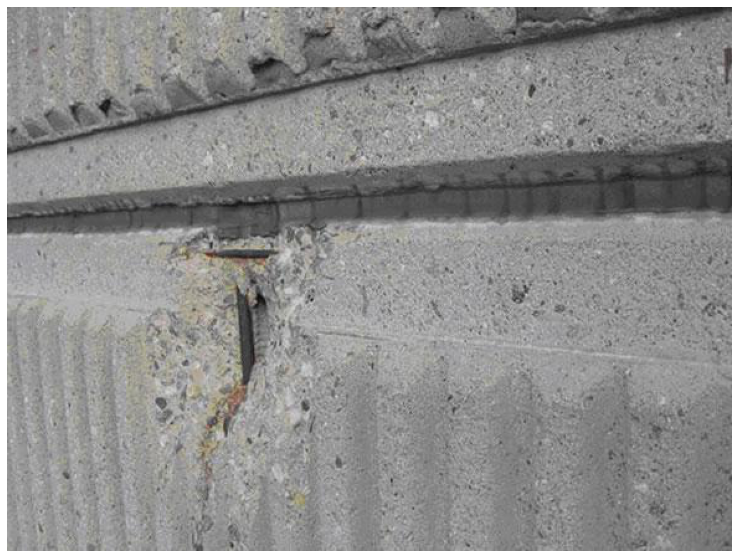

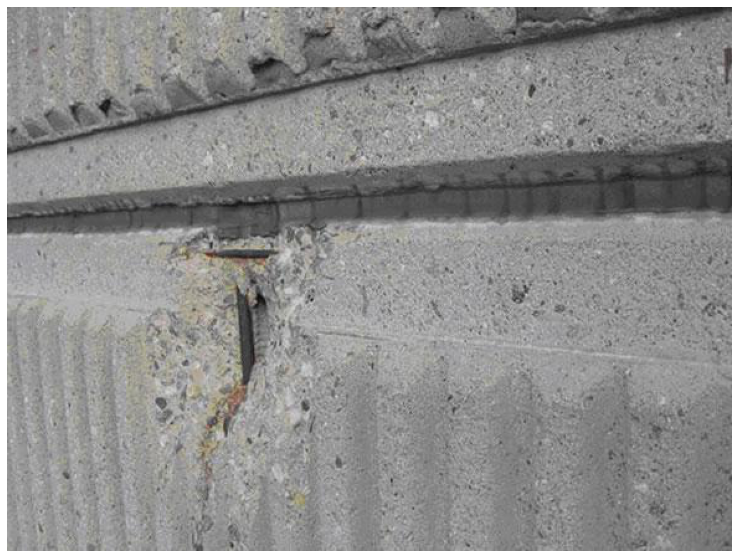

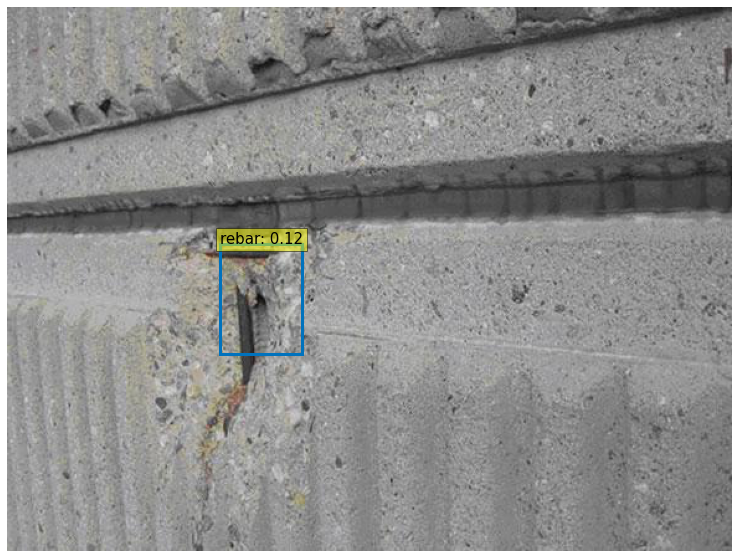

In [20]:
from PIL import Image

img_name = "/home/wenisch/Atom360/AI/Learning/data/dataset/images/00019.jpg"
im = Image.open(img_name)


run_worflow(im,
            model)

{'pred_logits': tensor([[[-13.3356,  -1.7539,  -2.5086,   3.3329],
         [-13.5582,  -0.7533,  -1.6651,   2.2053],
         [-14.7930,  -1.2610,  -1.4511,   2.6540],
         [-13.9225,  -0.8857,  -1.6438,   2.4021],
         [-13.7185,  -0.8591,  -0.9918,   2.0064],
         [-14.8783,  -1.1205,  -1.0944,   2.4070],
         [-13.5941,  -1.0186,  -1.1960,   2.1597],
         [-14.3287,  -1.2676,  -1.2429,   2.6182],
         [-14.5805,  -1.0095,  -1.0347,   2.5901],
         [-14.7221,  -0.8805,  -1.5307,   2.7963],
         [-13.7371,  -1.3280,  -2.1979,   2.6223],
         [-14.2888,  -1.3970,  -1.9267,   2.8953],
         [-14.7780,  -0.8963,  -2.2089,   2.7822],
         [-13.9330,  -1.0474,  -1.9658,   2.6579],
         [-13.5820,  -1.0937,  -1.4222,   2.1559],
         [-14.6799,  -1.1428,  -1.8081,   2.7560],
         [-13.9844,  -1.9046,  -2.5285,   3.4868],
         [-14.7582,  -0.8055,  -1.8386,   2.5832],
         [-14.0595,  -0.8452,  -1.9285,   2.3545],
         [-14.5

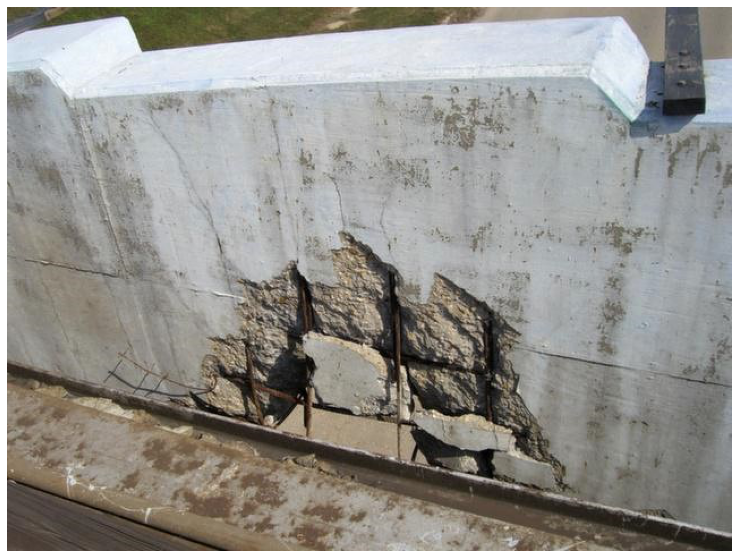

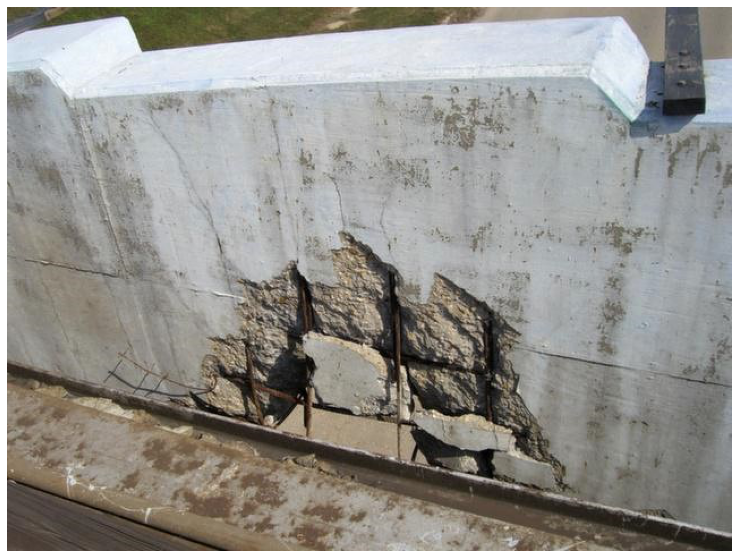

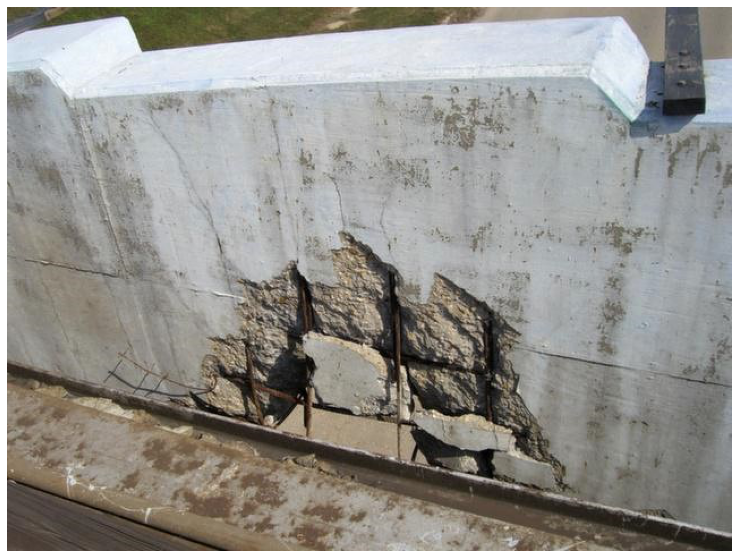

In [21]:
from PIL import Image

img_name = "/home/wenisch/Atom360/AI/Learning/data/dataset/images/00018.jpg"
im = Image.open(img_name)

run_worflow(im,
            model)